##### Imports

In [10]:
from operator import itemgetter

from itertools import combinations 
from typing import Any, Dict, List

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt

import aim

from skimage.draw import disk
from skimage.transform import AffineTransform, warp

from medpy.metric.binary import dc

from monai.metrics import DiceMetric, HausdorffDistanceMetric, compute_meandice
from monai.transforms import AsDiscrete, EnsureType, Compose
from monai.data import decollate_batch
from monai.losses import DiceLoss
from monai.networks import one_hot

import plotly.express as px

import kornia.augmentation as K

import torch
from torch import nn
from torch.utils.data.dataloader import default_collate
from torch.utils.data import DataLoader, TensorDataset

from kedro.extras.datasets.pickle import PickleDataSet

In [11]:
import os, sys
sys.path.append(os.path.abspath('../src'))

from tagseg.models.segmenter import Net
from tagseg.models.trainer import Trainer
from tagseg.data.utils import load_nii
from tagseg.metrics.shape import ShapeDistLoss
from tagseg.pipelines.data_splitting.nodes import split_data

In [12]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


##### Fetch data

Extract cherry-picked example to test augmentation strategy on and squeeze to remove channel dimension

In [13]:
path_image = '../data/01_raw/acdc-training/patient080/patient080_frame10.nii.gz'
path_label = '../data/01_raw/acdc-training/patient080/patient080_frame10_gt.nii.gz'

images, label = tuple(map(lambda p: load_nii(p)[0].swapaxes(0, 2), (path_image, path_label)))

print(f'Image of shape: {images.shape}, Label of shape: {label.shape}')

Image of shape: (6, 256, 216), Label of shape: (6, 256, 216)


Let's make the image between 0 and 255

In [14]:
im = images[2].astype(np.uint8)
la = label[2]

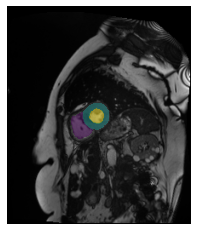

In [15]:
plt.imshow(im, cmap='gray')
plt.imshow(np.ma.masked_where(la == 0, la), cmap='viridis', alpha=0.5)
plt.axis('off')
plt.show()

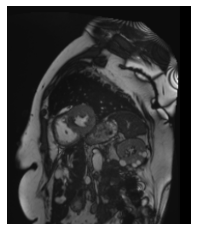

In [16]:
tform = AffineTransform(scale=.97, translation=(20, 0))
warped = warp(im, tform)

plt.imshow(warped, cmap='gray')
plt.axis('off')
plt.show()

- Works for normal breathing, might not generalize to **intense** breathing

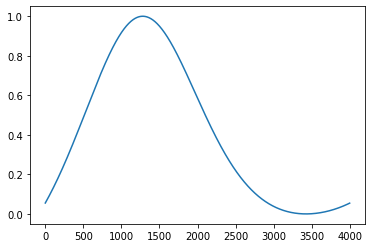

In [30]:
duration = 4000
timepoints = np.arange(duration)

# Compute x and y coordinates
now = (timepoints / (duration * 1.25)) % duration
spike = np.exp(np.sin(now * 2 * np.pi)) + 0.5 * np.exp(now)

# Normalize to [0, 1]
spike = (spike - spike.min()) / (spike.max() - spike.min())

plt.plot(timepoints, spike)

Let's transform the image to get the k-space representation

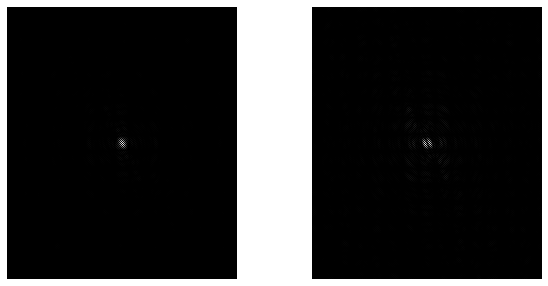

In [18]:
kspace = scp.fft.fftshift(
    scp.fft.fft2(la)
)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(kspace.real, cmap='gray', clim=(.001 * kspace.real.max())), ax[0].axis('off')
ax[1].imshow(kspace.imag, cmap='gray', clim=(.001 * kspace.imag.max())),  ax[1].axis('off')

plt.show()

Perform the motion augmentation

_Simple version_
* Replace `x` rows with 0 randomly

_Moderate version_
* Create scaled and translated image
* Replace `x` random rows with the created image

_Complex version_
* Use a respiratory model that transforms image based on time of k-space row acquisition
* Create scaled and translated image for each row that will be replaced
* Replace rows with the created image for that specific row

In [19]:
def transformation_params(times: np.ndarray, breathing_duration: int = None) -> List[Dict[str, Any]]:

    if breathing_duration is None:
        breathing_duration = np.random.normal(4000, 750, size=1)

    now = (times / (breathing_duration * 1.25)) % breathing_duration
    f = np.exp(np.sin(now * 2 * np.pi)) + 5e-1 * np.exp(now)
    intensity = (f - f.min()) / (f.max() - f.min())
    
    s = 1 - (.5 * intensity)

    tx = np.zeros(times.shape[0])
    ty = - intensity * 150.
    
    d_of_l = dict(scale=s, translation=list(zip(*(tx, ty))))

    return [dict(zip(d_of_l, t)) for t in zip(*d_of_l.values())]

In [20]:
def get_row_time(
    rows: np.ndarray,
    segment_duration: int = 8,  # TR
    lines_per_segment: int = 4,
    heartbeat_duration: int = 1000,
    time_frame: int = 0
) -> np.ndarray:

    if heartbeat_duration is None:
        heartbeat_duration = np.random.normal(1200, 250, size=1)

    times = (rows % lines_per_segment) * segment_duration + (rows // lines_per_segment) * heartbeat_duration 
    times += time_frame * lines_per_segment * segment_duration
    
    return (times).astype(np.int32)

- TR should probably me around 5 ms
- Only 55 - 60 of lines are actually sampled (with grappa)
    - Not sure this matters if we get the reconstructed image anyways (jump should be every segment)
- Grappa2 goes twice as fast (skips every other lines)

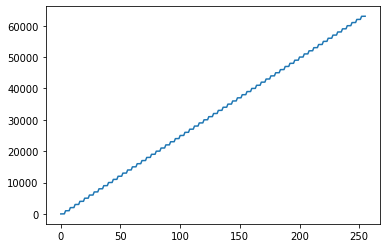

In [21]:
rows = np.arange(256)
times = get_row_time(rows)

plt.plot(rows, times)

In [22]:
def to_kspace(image: np.ndarray):
    return scp.fft.fftshift(scp.fft.fft2(scp.fft.fftshift(image)))

def to_image(kspace: np.ndarray):
    return scp.fft.ifftshift(scp.fft.ifft2(scp.fft.ifftshift(kspace)))

def augment(image: np.array, method: str = 'moderate', replacement: str = 'periodic', amount: int = None):
    """Add motion artifacts to a 2D MRI image

    Args:
        image (np.array): 2D input image
        method (str, optional): Augmentation method, 'simple', 'moderate', or 'complex'. Defaults to 'moderate'.
        replacement (str, optional): Row replacement strategy, 'random' or 'periodic'. Defaults to 'period'.
        amonut (int, optional): Amount of rows replaced. Defaults to 10% of rows.
    """

    m, n = image.shape[-2:]

    kspace = to_kspace(image)
    
    modded_kspace = kspace.copy()

    if amount is None:
        amount = m // 10

    if replacement == 'periodic':
        replacement_rows = np.linspace(0, n, amount, endpoint=False, dtype=np.int32)
        
    elif replacement == 'random':
        replacement_rows = np.random.randint(0, n, amount)

    else:
        raise ValueError(f'replacement should be either periodic or random. Got {replacement}.')

    if method == 'simple':
        modded_kspace[:, replacement_rows] = np.zeros((m, 1))
        
    elif method == 'moderate':
        # Create transform
        tform = AffineTransform(scale=1.1, translation=(10, 10))
        # Create fake image the simulates breathing
        warped_image = warp(image, tform)
        # Transform into kspace
        breathing_kspace = to_kspace(warped_image)
        
        modded_kspace[:, replacement_rows] = breathing_kspace[:, replacement_rows]

    elif method == 'complex':        
        # get times according to row index
        times = get_row_time(replacement_rows)
        # get transformation parameters according to time in ms
        # this uses our respiratory model
        row_trans_params = transformation_params(times)
        # create transformed image for each row
        # by creating an AffineTransform instance and calling warp foreach
        
        # tforms = list(map(lambda ps: AffineTransform(**ps), row_trans_params))
        # fake_ims = list(map(lambda tf: warp(image, tf), tforms))
        # breathing_kspaces = list(map(
        #     lambda fim: to_kspace(fim), 
        #     fake_ims
        # ))
        # for row, bksp in zip(replacement_rows, breathing_kspaces):
        #     modded_kspace[:, row] = bksp[:, row]

        for row, ps in zip(replacement_rows, row_trans_params):

            # TODO: perform affine transformation in k-space
            tform = AffineTransform(**ps)
            fake_image = warp(image, tform)
            altered_kspace = to_kspace(fake_image)
            modded_kspace[:, row] = altered_kspace[:, row]

    else:
        raise ValueError(f'method should be simple or moderate. Got {method}.')

    return np.abs(to_image(modded_kspace))  # , tforms, fake_ims, replacement_rows

Plot the augmented image

In [23]:
def normalize(a):
    return (a - a.min()) / (a.max() - a.min())

In [ ]:
%lprun -f augment augment(im, method='complex', replacement='periodic', amount=216)

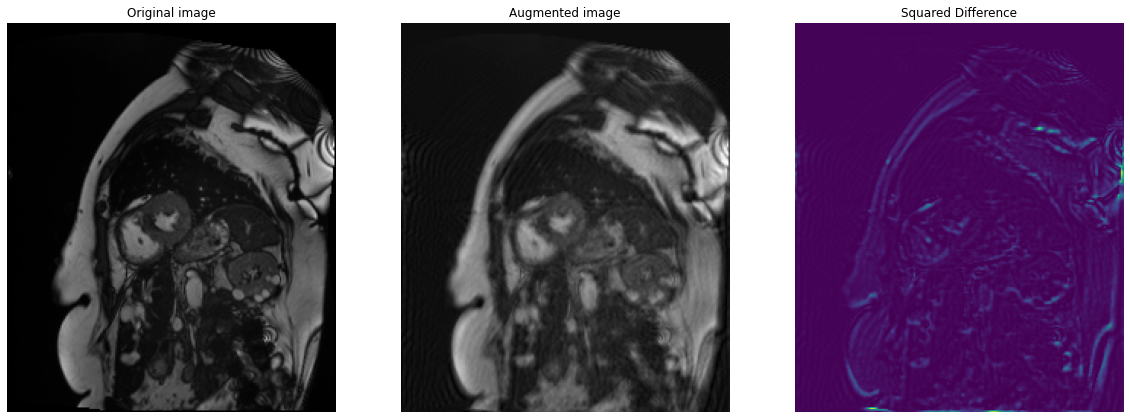

In [37]:
aug = augment(im, method='complex', replacement='periodic', amount=216)
# aug, tforms, fims, replacement_rows = augment(im, method='complex', replacement='periodic', amount=216)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(im, cmap='gray'), ax[0].axis('off'), ax[0].set_title('Original image')
ax[1].imshow(aug, cmap='gray'), ax[1].axis('off'), ax[1].set_title('Augmented image')
ax[2].imshow((normalize(im) - normalize(aug)) ** 2, cmap='viridis'),  ax[2].axis('off'), ax[2].set_title('Squared Difference')

plt.show()

##### Additional evaluation

In [26]:
n = len(tforms)

diffs = np.empty((n, n), dtype=np.float64)

for i, j in combinations(range(len(tforms)), 2):
    diffs[i, j] = ((tforms[i].params - tforms[j].params) ** 2).mean()

plt.imshow(diffs)
plt.colorbar()

NameError: name 'tforms' is not defined

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

class VideoAnimation:

    def __init__(self, imt: np.ndarray):

        self.imt = imt

        self.fig, self.axarr = plt.subplots(1, 1, squeeze=False, figsize=(8, 8))
        self.fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        self.im = self.axarr[0, 0].imshow(self.imt[0], cmap="gray")
        self.axarr[0, 0].axis('off')

        self.anim = animation.FuncAnimation(
            self.fig,
            self.animate,
            init_func=self.init_animation,
            frames=imt.shape[0],
            interval=50,
            blit=True
        )

        plt.close()

    def init_animation(self):
        self.im.set_data(self.imt[0])
        return [self.im,]

    def animate(self, i):
        self.im.set_data(self.imt[i])
        return [self.im,] 

In [ ]:
va = VideoAnimation(np.array(fims))
HTML(va.anim.to_jshtml())

In [ ]:
total = len(fims)

m, n = np.ceil(total / 6).astype(int), 6

fig, ax = plt.subplots(m, n, figsize=(15, m * 4))

for i in range(total):

    ax[i // n, i % n].imshow(fims[i])
    ax[i // n, i % n].axis('off')
    ax[i // n, i % n].set_title(f'{i:02}')